# Miniproject: Support Vector Machines

## Machine Learning, Winter 2017

### Name: [Your name here]

In this miniproject, you will:

* Tune an SVM to fit multiple "standard" datasets to explore kernels
* Classify image data with an SVM
* Preprocess that image data using a convolution.

In [16]:
# Standard import statements:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.decomposition import PCA
import os
import random
from sklearn.pipeline import make_pipeline
from skimage import io, transform

%matplotlib inline

plt.style.use("ggplot")

In [2]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolor="k");
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# The Scikit-learn `SVC` class and kernels

Here `SVC` stands for Support Vector Classifier and it has many features.  The most important thing to note to begin with is it takes a `kernel` keyword argument, and the default is the [Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function), because it's so successful.  But it's a bit aggressive for linearly or near-linearly separable data.  For that, you should use `kernel='linear'`.

### Linear Kernel

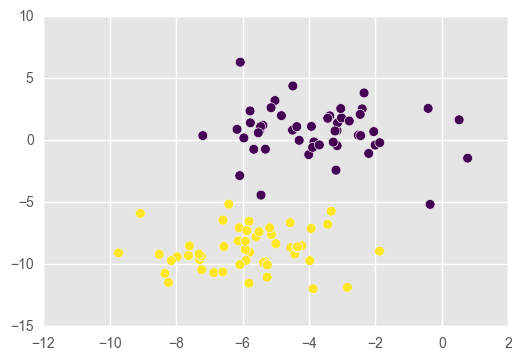

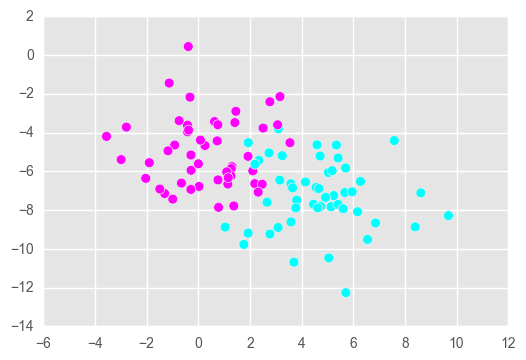

In [3]:
# Here are the datasets you're working` with, to start:
X_1, y_1 = make_blobs(centers=2, cluster_std=1.7, random_state=17)
X_2, y_2 = make_blobs(centers=2, cluster_std=1.7, random_state=12)
X_2[:,[0, 1]] = X_2[:,[1, 0]] ## swap columns to reflect in the line y=x
plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, s=50, cmap='viridis')
plt.show();
plt.scatter(X_2[:, 0], X_2[:, 1], c=y_2, s=50, cmap='cool')
plt.show();

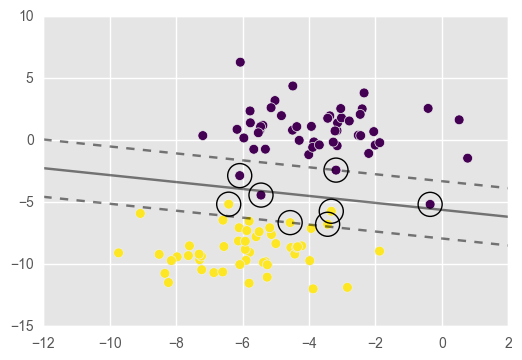

In [4]:
lin1 = SVC(kernel='linear',C=0.05)
lin1.fit(X=X_1, y=y_1)
plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, s=50, cmap='viridis')
plot_svc_decision_function(lin1)

We prioritized a wider margin here as most of the data is clustered farther away from the decision boundary with only a few outliers in the middle region. To do this we reduced the c value to 0.05.

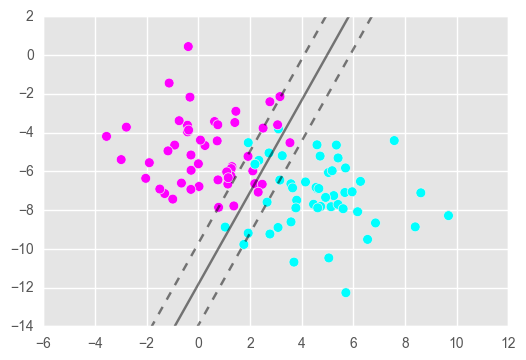

In [5]:
lin2 = SVC(kernel='linear')
lin2.fit(X=X_2, y=y_2)
plt.scatter(X_2[:, 0], X_2[:, 1], c=y_2, s=50, cmap='cool')
plot_svc_decision_function(lin2, plot_support=False)

### Polynomial Kernel and RBF

For the polynomial kernel, you'll need to specify a degree number using `kernel='poly'` and `degree=3` (for degree-3).  Clearly, higher-degree polynomial kernels are more variant, and lower-degree polynomial kernels are more variant.  For a `poly` kernel, you can also try adding a `coef0` term (and feel free to ask me what that means, or find out for yourself!).  For an RBF kernel, there's a hyperparameter that's either called $\gamma$ or $\epsilon$ (and one is $\dfrac{1}{2\pi \cdot\text{(the other one)}}$), that acts in a similar bias-variance way.

1. Fit a SVM with polynomial kernel of varying degrees to each of these datasets.
2. Fit a SVM with RBF kernel of varying amounts of $\gamma$.
3. Attempt to use your results to determine a relationship/function of *"Similar bias/variance"* relating `degree` in a polynomial kernel to `gamma` in an RBF kernel.  It won't be exact, it's just a rough comparison

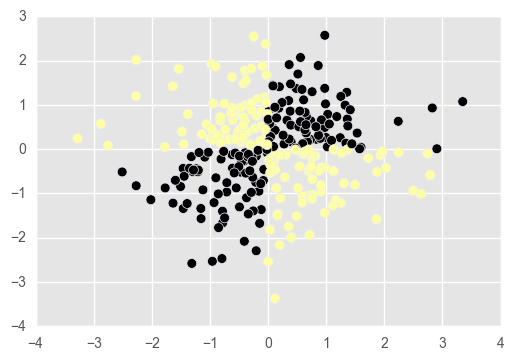

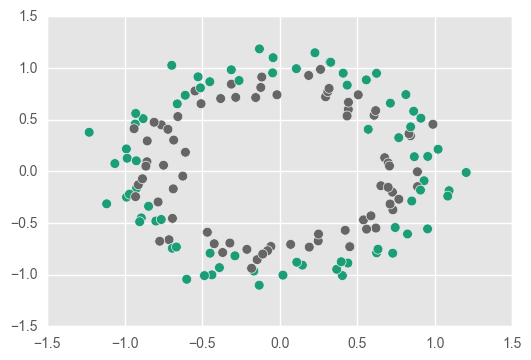

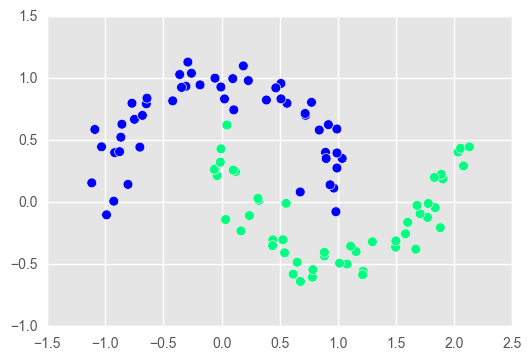

In [29]:
# Generate Datasets
X_3 = np.random.randn(300, 2)
y_3 = np.logical_xor(X_3[:, 0] > 0, X_3[:, 1] > 0).astype(int)
X_4, y_4 = make_circles(n_samples=150, shuffle=True, noise=0.1, random_state=11, factor=0.8)
X_4[:,[0, 1]] = X_4[:,[1, 0]]
X_5, y_5 = make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=13)

# Plot them
plt.scatter(X_3[:, 0], X_3[:, 1], c=y_3, s=50, cmap='inferno')
plt.show();
plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, s=50, cmap='Dark2')
plt.show();
plt.scatter(X_5[:, 0], X_5[:, 1], c=y_5, s=50, cmap='winter')
plt.show();

In [ ]:
# good luck!

# Image Classification

Now, we move on to image classification.  Let's begin with the `digits` dataset in Scikit-learn (A collection of handwritten digits which is a baby-version of the MNIST dataset):

In [7]:
digits = load_digits(return_X_y=True)
digits[0]

array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  10.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   9.,   0.],
       ..., 
       [  0.,   0.,   1., ...,   6.,   0.,   0.],
       [  0.,   0.,   2., ...,  12.,   0.,   0.],
       [  0.,   0.,  10., ...,  12.,   1.,   0.]])

Your tasks are as follows:
* Write a function `show(row)` to visualize the individual image at index `row` (just to make sure everything is working as intended).
* Train a SVM on the image dataset as it stands, tuning hyperparameters and aiming for the best fit.  (I say "as it stands" because in the [next section](#Convolutions-and-Preprocessing) you'll preprocess the images.)  
* Visualize your fit using PCA with the top two dimensions.  That is, fit a PCA to the dataset with two components, color the datapoints by their class.  You can attempt to plot a decision boundary by making a 64-dimensional meshgrid and pushing that through your model's `predict` and then the PCA transform (that would be cool if it worked), but you can also just change the plotting characters for your models correct-vs-incorrect classifications.  You may want to view notebook on PCA from before break for a refresher.
I recommend, but do not require, that you first subsample down to two classes (say, 1's and 0's) before moving on to the multi-class problem.

In [ ]:
# good luck!

# Convolutions and Preprocessing

This image data is pretty high-dimensional.  There are two preprocessing techniques I'd like for you to try:

1. PCA -- Fit a PCA to your data, and try to reduce the dimensionality of your data by some (probably small-ish?) factor.  Create a plot of "Dimensions Remaining" versus "Best fit model at 
2. Try to preprocess your data using a **convolution**.  This is the mathematical term for what photoshoppers call a *filter*.  What you need to do is this: write a method `convolve(data, matrix)` that takes a matrix of data points (really a row of your dataset) and a $3\times 3$ matrix and returns a new matrix (really a row of your new dataset) of data whereby the $(i,j)^{\text{th}}$ entry is the sum of the products of the elements surrounding $(i,j)^{\text{th}}$ entry in the entry data matrix.  Here's a picture:

 <img src="http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png">

 And here's an example gif:

 <img src="http://deeplearning.net/software/theano/_images/numerical_no_padding_no_strides.gif">

 Here the "data matrix/row" is the big $5\times 5$ matrix on the left, the output matrix is the $3\times 3$ matrix on the right, and the convolution matrix (what they confusingly call the "kernel" above) is:

 $$\left(\begin{array}{ccc} 0 & 1 & 2 \\ 2 & 2 & 0 \\ 0 & 1 & 2 \end{array}\right)$$

 Here's a [blog post](http://colah.github.io/posts/2014-07-Understanding-Convolutions/) that goes into more detail than y'all need, but look through the pictures in the "Higher Dimensional Convolutions" section.  
 
 Okay, but what matrix should you use as your convolution matrix?  Ones that help to *detect edges* are
 
 $$\left(\begin{array}{ccc} 0 & -\frac{1}{4} & 0 \\ -\frac{1}{4} & 1 & -\frac{1}{4} \\ 0 & -\frac{1}{4} & 0 \end{array}\right)\qquad \text{and} \qquad \left(\begin{array}{ccc} -\frac{1}{9} & -\frac{1}{9} & -\frac{1}{9} \\ -\frac{1}{9} & 1 & -\frac{1}{9} \\ -\frac{1}{9} & -\frac{1}{9} & -\frac{1}{9} \end{array}\right).$$

 try both of these out.  Which works better? 
3. Put these two together: after completing both of the above, try fitting a PCA to your convolved data (note: the word used typically is *convolved*, not *convoluted*, though many people [myself included] accidentally say the latter at times)



In [ ]:
# good luck!

# "Real" Images

The following collection of datasets are of full-color, "real" images.  I don't want you to spend a ton of time trying to make a perfect classifier for these -- just pick one, potentially do some downsampling (take only a fraction of the dataset, because we're just learning how to do this, not doing this for a job), preprocessing (as before), and make sure that you can visualize the images and your classifier (again, use PCA).

* [Cats vs. Dogs](https://www.kaggle.com/c/dogs-vs-cats/data) -- 25,000 images of cats and dogs (binary classification).  It's a big download, and you almost certainly don't need the full dataset to get some progress with classifying them.  Virtual bonus points for making Dr. Z say "Awwww!" while grading your notebook.
* The real [MNIST](http://yann.lecun.com/exdb/mnist/) dataset -- the one we were working on above is a simpler one to classify (I think?), the real dataset has for more samples and is higher dimensional (higher resolution). You may find [this resource](http://scikit-learn.org/stable/datasets/#downloading-datasets-from-the-mldata-org-repository) useful.
* The [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) -- images in 101 categories (feel free to group objects into larger categories, or downsample to only a few categories).
* Any other image dataset that you can find!  Do you want to create a classifier to tell jeeps from pickups? Stars from galaxies?  Go for it!  Just remember to also study for your test.

(500, 500, 3)


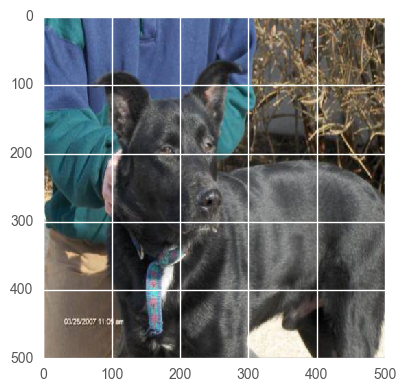

In [3]:
path = "data/train"
training_list = random.sample(os.listdir(path), 1000)
#print(training_list)

test = io.imread(path+'/'+training_list[0])
test = transform.resize(test, (500,500))
print(test.shape)
io.imshow(test)

In [4]:
GRAYSCALE = True
if GRAYSCALE:
    SCALE_FACTOR = 1
else:
    SCALE_FACTOR = 3

identify = lambda x: 0 if x == "cat" else 1 #cat=0, dog=1

images = []
y_ani = []

for file in training_list:
    y_ani.append(identify(file.split(".")[0]))
    tgt = io.imread(path+'/'+training_list[0], as_grey=GRAYSCALE)
    images.append(transform.resize(tgt, (500,500)))

images = np.array(images)
y_ani = np.array(y_ani)

images.shape

(1000, 500, 500)

In [5]:
X_ani = images.reshape(1000,500*500*SCALE_FACTOR)

In [6]:
pca = PCA(n_components=100, svd_solver='randomized')
pca.fit(X_ani)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

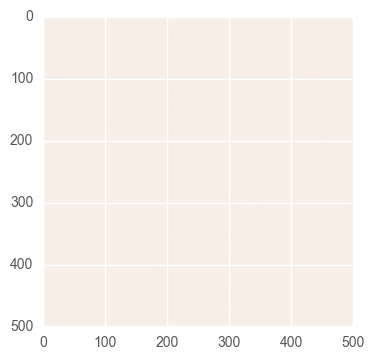

In [12]:
plt.imshow(pca.components_[32].reshape(500,500), cmap='RdBu')